In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [3]:
dataset = pandas.read_csv('datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [4]:
dataset.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


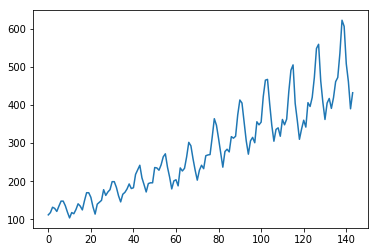

In [5]:
plt.plot(dataset)
plt.show()
plt.clf()

In [6]:
# normalize the dataset by rescaling the data to the range of 0-to-1 since LSTMs are sensitive to the scale of the input data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

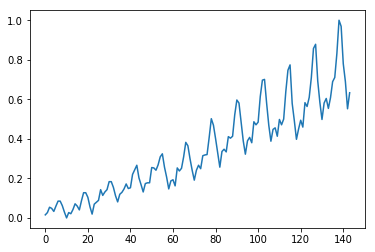

In [7]:
plt.plot(dataset)
plt.show()
plt.clf()

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return numpy.array(dataX), numpy.array(dataY)

In [19]:
# reshape into X=t and Y=t+1
look_back = 1 # try with 3 for LSTM using the Window Method so we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables
train_data, train_labels = create_dataset(train, look_back)
test_data, test_labels = create_dataset(test, look_back)

In [11]:
# the LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features]
train_data = numpy.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = numpy.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

In [12]:
# create and fit the LSTM network
model_arlpassenger = Sequential()
model_arlpassenger.add(LSTM(4, input_shape=(1, look_back)))
model_arlpassenger.add(Dense(1))
model_arlpassenger.compile(loss='mean_squared_error', optimizer='adam')
model_arlpassenger.fit(train_data, train_labels, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0202
Epoch 3/100
 - 0s - loss: 0.0145
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

In [13]:
# make predictions
train_predict = model_arlpassenger.predict(train_data)
test_predict = model_arlpassenger.predict(test_data)

In [14]:
# invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data
train_predict = scaler.inverse_transform(train_predict)
train_labels = scaler.inverse_transform([train_labels])
test_predict = scaler.inverse_transform(test_predict)
test_labels = scaler.inverse_transform([test_labels])

In [15]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_labels[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_labels[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 22.92 RMSE
Test Score: 47.53 RMSE


We can see that the model has an average error of about 22 passengers (in thousands) on the training dataset, and about 47 passengers (in thousands) on the test dataset. Impressive model!

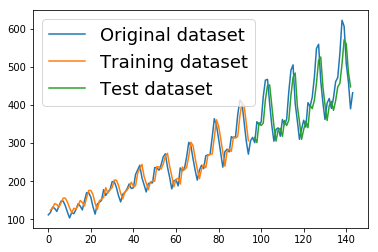

In [16]:
# because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset
# shift train predictions for plotting
train_predict_plot = numpy.empty_like(dataset)
train_predict_plot[:, :] = numpy.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
test_predict_plot = numpy.empty_like(dataset)
test_predict_plot[:, :] = numpy.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.legend(['Original dataset', 'Training dataset', 'Test dataset'],fontsize=18)
plt.show()

In [17]:
# serialize model to JSON
model_arlpassenger_json = model_arlpassenger.to_json()
with open("weights/model_arlpassenger.json", "w") as json_file:
    json_file.write(model_arlpassenger_json)
    
# serialize weights to HDF5
model_arlpassenger.save_weights("weights/model_arlpassenger.h5")
print("Model saved to disk...")

Model saved to disk...


<hr/>